In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [ ]:
pip install -U datasets transformers peft accelerate scikit-learn matplotlib


In [ ]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [ ]:
emotion_labels = dataset["train"].features["label"].names
print(emotion_labels)
# ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
label2emotion = {i: l for i, l in enumerate(emotion_labels)}

risk_map = {
    "joy": 0, "love": 0, "surprise": 0,
    "anger": 1, "fear": 1,
    "sadness": 2,
}

def add_risk(example):
    emo = label2emotion[example["label"]]
    example["risk"] = risk_map[emo]
    return example

dataset = dataset.map(add_risk)


['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

base_model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=6  # six emotion labels
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# HuggingFace Trainer 要的是 torch tensor
tokenized_datasets.set_format("torch")


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotion_names = ["joy", "love", "surprise", "anger", "fear", "sadness"]

zero_shot_template = """You are a psychologist analyzing social media posts.
Classify the emotion of the following post into exactly one of:
{labels}.

Post: "{text}"

Answer with only the emotion word.
"""

def build_zero_shot_prompt(text):
    return zero_shot_template.format(
        labels=", ".join(emotion_names),
        text=text
    )


In [ ]:
few_shot_examples = [
    ("I feel so happy today, everything is perfect!", "joy"),
    ("I miss you so much, my heart hurts.", "sadness"),
    ("You are the love of my life.", "love"),
]

few_shot_template = """You are a psychologist analyzing social media posts.
Below are some example posts and their emotion labels.

{examples}

Now classify the emotion of the following post into exactly one of: {labels}.

Post: "{text}"

Answer with only the emotion word.
"""

def build_few_shot_prompt(text):
    ex_str = "\n".join(
        [f'Post: "{t}" -> {lab}' for t, lab in few_shot_examples]
    )
    return few_shot_template.format(
        examples=ex_str,
        labels=", ".join(emotion_names),
        text=text
    )


In [ ]:
import torch

def parse_emotion_from_output(output_text):
    output_text = output_text.lower()
    # 找到第一個出現的 label
    for emo in emotion_names:
        if emo in output_text:
            return emo
    # 找不到就當作 'sadness' or anything, 但記得報告裡要說這樣很粗糙
    return "sadness"

def predict_emotion_zero_shot(text, generate_fn):
    prompt = build_zero_shot_prompt(text)
    out = generate_fn(prompt)
    emo = parse_emotion_from_output(out)
    return emo

def predict_emotion_few_shot(text, generate_fn):
    prompt = build_few_shot_prompt(text)
    out = generate_fn(prompt)
    emo = parse_emotion_from_output(out)
    return emo


In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# 這邊先不做量化（Q-LoRA）版本，直接用 FP16 + LoRA 就好
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "key", "value"],  # BERT attention 中常見的名稱
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 446,982 || all params: 109,933,836 || trainable%: 0.4066


In [ ]:
import transformers
print(transformers.__version__)
from transformers import TrainingArguments
TrainingArguments.__module__

4.57.1


'transformers.training_args'

In [ ]:
# 先確保 emotion_labels 在這個 runtime 裡
emotion_labels = dataset["train"].features["label"].names

from transformers import Trainer  # 已經 import 過也沒關係

def compute_metrics(eval_pred):
    import numpy as np
    from sklearn.metrics import f1_score

    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Emotion F1 (macro)
    f1_emotion = f1_score(labels, preds, average="macro")

    # Emotion -> Risk，不再用 id2label，而是直接用 emotion_labels[x]
    emo2risk_vec = np.vectorize(lambda x: risk_map[emotion_labels[x]])
    y_true_risk = emo2risk_vec(labels)
    y_pred_risk = emo2risk_vec(preds)
    f1_risk = f1_score(y_true_risk, y_pred_risk, average="macro")

    return {
        "f1_emotion_macro": f1_emotion,
        "f1_risk_macro": f1_risk,
    }

# 把新的 compute_metrics 掛回既有的 trainer（不用重練）
trainer.compute_metrics = compute_metrics


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # 要的話也可以拿掉，改用 report_to="none"

from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    import numpy as np
    from sklearn.metrics import f1_score

    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Emotion F1 (macro)
    f1_emotion = f1_score(labels, preds, average="macro")

    # Emotion -> Risk（直接用 emotion_labels）
    emo2risk_vec = np.vectorize(lambda x: risk_map[emotion_labels[x]])
    y_true_risk = emo2risk_vec(labels)
    y_pred_risk = emo2risk_vec(preds)
    f1_risk = f1_score(y_true_risk, y_pred_risk, average="macro")

    return {
        "f1_emotion_macro": f1_emotion,
        "f1_risk_macro": f1_risk,
    }

training_args = TrainingArguments(
    output_dir="./emotion-lora",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_steps=100,
    report_to="none",   # 關掉 wandb 之類的外部 logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

eval_results = trainer.evaluate(tokenized_datasets["validation"])
print(eval_results)


/tmp/ipython-input-4221751584.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,1.542400
200,1.215900
300,0.949200
400,0.843200
500,0.747000
600,0.652500
700,0.581600
800,0.540900
900,0.519600
1000,0.489800


{'eval_loss': 0.34440547227859497, 'eval_f1_emotion_macro': 0.8624007316830872, 'eval_f1_risk_macro': 0.9387358058541665, 'eval_runtime': 15.2666, 'eval_samples_per_second': 131.005, 'eval_steps_per_second': 2.096, 'epoch': 3.0}


In [ ]:
import torch
from torch.nn.functional import softmax

test_ds = tokenized_datasets["test"]

with torch.no_grad():
    outputs = trainer.predict(test_ds)

logits = outputs.predictions
labels = outputs.label_ids   # emotion (0–5)
preds = np.argmax(logits, axis=-1)

# Emotion → Risk
emo2risk_vec = np.vectorize(lambda x: risk_map[id2label[x]])
y_true_risk = emo2risk_vec(labels)
y_pred_risk = emo2risk_vec(preds)

# 取得機率
probs = softmax(torch.tensor(logits), dim=-1).numpy()
# 每一筆的 high_risk 機率 = 所有屬於 sadness 的 logit，這裡就是 label 'sadness' 的 index
idx_sadness = emotion_labels.index("sadness")
p_high_risk = probs[:, idx_sadness]


In [ ]:
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import label_binarize

# F1 (多類)
f1_risk_macro = f1_score(y_true_risk, y_pred_risk, average="macro")
print("F1 (risk, macro):", f1_risk_macro)

# AUROC / PR-AUC (多類 one-vs-rest)
y_true_onehot = label_binarize(y_true_risk, classes=[0, 1, 2])

# 我們現在只有 p_high_risk，嚴格說 multi-class AUROC 要 3 類的機率
# 簡化做法：專注在「高風險 vs 非高風險」二元問題：
y_true_binary = (y_true_risk == 2).astype(int)  # 1 = high_risk
y_pred_binary = (y_pred_risk == 2).astype(int)

auroc = roc_auc_score(y_true_binary, p_high_risk)
pr_auc = average_precision_score(y_true_binary, p_high_risk)

print("AUROC (high_risk vs others):", auroc)
print("PR-AUC (high_risk vs others):", pr_auc)

# Confusion Matrix（三類 risk）
cm = confusion_matrix(y_true_risk, y_pred_risk, labels=[0,1,2])
print("Confusion Matrix (risk):\n", cm)

print("Classification report (risk):")
print(classification_report(y_true_risk, y_pred_risk, target_names=["low","mid","high"]))


F1 (risk, macro): 0.9295525505452512
AUROC (high_risk vs others): 0.9854773973574759
PR-AUC (high_risk vs others): 0.9752822583749479
Confusion Matrix (risk):
 [[894   7  19]
 [ 26 439  34]
 [ 12  28 541]]
Classification report (risk):
              precision    recall  f1-score   support

         low       0.96      0.97      0.97       920
         mid       0.93      0.88      0.90       499
        high       0.91      0.93      0.92       581

    accuracy                           0.94      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.94      0.94      0.94      2000



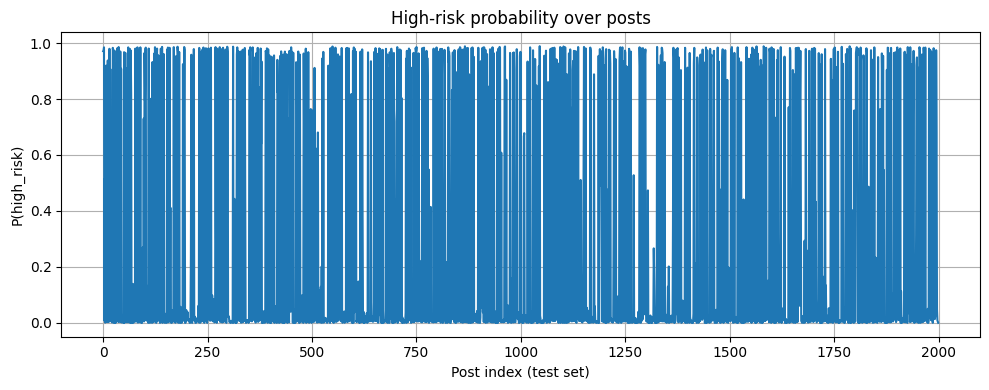

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

indices = np.arange(len(p_high_risk))

plt.figure(figsize=(10, 4))
plt.plot(indices, p_high_risk)
plt.xlabel("Post index (test set)")
plt.ylabel("P(high_risk)")
plt.title("High-risk probability over posts")
plt.grid(True)
plt.tight_layout()
plt.show()


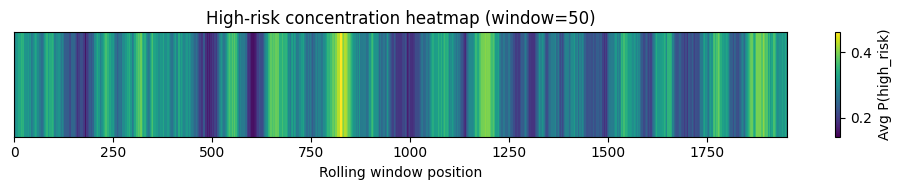

In [ ]:
window = 50
kernel = np.ones(window) / window
rolling_high = np.convolve(p_high_risk, kernel, mode="valid")

plt.figure(figsize=(10, 2))
plt.imshow(
    rolling_high[np.newaxis, :],  # 變成 1 × N
    aspect="auto",
    interpolation="nearest"
)
plt.colorbar(label="Avg P(high_risk)")
plt.yticks([])  # 不需要 y 軸
plt.xlabel("Rolling window position")
plt.title(f"High-risk concentration heatmap (window={window})")
plt.tight_layout()
plt.show()
